# TODO:
"""
    Решающее правило
    
    Набрать статистику по каждому сэмплу как выход с сетки
    
    Замерить время обучения
    
    Представимость квантовой стеки"""

In [1]:
import tensorflow as tf
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt

# from strawberryfields import ops
from strawberryfields.ops import Dgate, BSgate, Sgate, Rgate, Pgate

from qmlt.tf import CircuitLearner
from qmlt.tf.helpers import make_param

from sklearn.utils import shuffle
from sklearn import datasets
import numpy as np

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
steps = 1060
batch_size = 2
qmodes = 4
params_num = 7
circuit_weights = []
load_params = False

In [3]:
def visualize_dataset(trainX, trainY) -> None:
    fig, axs = plt.subplots(nrows=4, ncols=4)

    colors = ['red', 'blue', 'green']
    test_colors = ['purple', 'black', 'yellow']

    for i in range(4):
        for j in range(4):
            for k in np.unique(trainY, axis=0):
                axs[i % 4, j % 4].plot(trainX[trainY == k, i],
                                       trainX[trainY == k, j],
                                       'o', label='class {}'.format(k), color=colors[k]
                                       )

                axs[i % 4, j % 4].legend(fontsize=5,
                                         ncol=1,
                                         facecolor='oldlace',
                                         edgecolor='r'
                                         )

                # axs[i % 4, j % 4].set_xlim(-1, 10)
                # axs[i % 4, j % 4].set_ylim(-1, 10)

    fig.set_size_inches(10., 6.5)
    plt.show()

In [4]:
def create_dataset():

    iris = datasets.load_iris()
    x = iris.data
    Y = iris.target
    
    visualize_dataset(x, Y)
    
    y = []
    for i in range(len(Y)):
        if Y[i] == 0:
            y.append([1., 0., 0.])
        elif Y[i] == 1:
            y.append([0., 1., 0.])
        elif Y[i] == 2:
            y.append([0., 0., 1.])

    x, y = shuffle(x, np.array(y), random_state=1917)
#     x, y = shuffle(x, Y, random_state=7)
    
    sep = round(len(x) * 0.1)
    
    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    return train_x, train_y, test_x, test_y

In [5]:
steps = 700


def circuit(X):
    
    params = [make_param(name='phi'+str(i), constant=.5, monitor=True, regularize=False) for i in range(7)]

    eng, q = sf.Engine(4)

    quater_pi = tf.constant(np.pi / 4)
    with eng:
        Sgate(1.5, X[:, 0]) | q[0]
        Sgate(1.5, X[:, 1]) | q[1]
        Sgate(1.5, X[:, 2]) | q[2]
        Sgate(1.5, X[:, 3]) | q[3]
        BSgate(quater_pi, 0) | (q[0], q[1])
        BSgate(quater_pi, 0) | (q[2], q[3])
        Rgate(params[0]) | q[0]
        Rgate(params[1]) | q[1]
        Rgate(params[2]) | q[2]
        BSgate(quater_pi, 0) | (q[1], q[2])
        Rgate(params[3]) | q[1]
        Dgate(params[4]) | q[0]
        Dgate(params[5]) | q[1]
        Dgate(params[6]) | q[2]
#         Pgate(params[8]) | q[0]
#         Pgate(params[9]) | q[1]
#         Pgate(params[10]) | q[2]

    num_inputs = X.get_shape().as_list()[0]
    state = eng.run('tf', cutoff_dim=5, eval=False, batch_size=num_inputs)

    p0 = state.fock_prob([2, 0, 0, 0])
    p1 = state.fock_prob([0, 2, 0, 0])
    p2 = state.fock_prob([0, 0, 2, 0])
    normalization = p0 + p1 + p2 + 1e-10
    circuit_output = tf.transpose([p0 / normalization, p1 / normalization, p2 / normalization])

    return circuit_output


def myloss(circuit_output, targets):
    return  tf.losses.softmax_cross_entropy(
                                        logits= circuit_output, 
                                        onehot_labels=targets
                                        )


def outputs_to_predictions(output):
    return tf.one_hot(tf.argmax(output, 1), 3)

def myregularizer(regularized_params):
    return tf.nn.l2_loss(regularized_params)

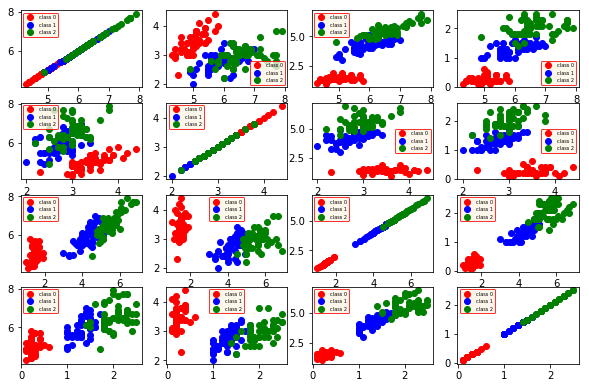

In [6]:
train_x, train_y, test_x, test_y = create_dataset()

# print(train_y)

In [7]:
hyperparams = {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'Adam',
               'init_learning_rate': 0.0055,
               'print_log': True,
               'log_every': 1,
               'warm_start': False,
               }
# steps = range(1, 1001, 100)
steps = [1001]

test_acc, test_loss = [], []
train_acc, train_loss = [], []

for step in steps:

    learner = CircuitLearner(hyperparams=hyperparams)

    train_history = learner.train_circuit(X=train_x, Y=train_y, steps=step, batch_size=batch_size)
    
    train_score = learner.score_circuit(X=train_x, Y=train_y,
                                       outputs_to_predictions=outputs_to_predictions)
    
    test_score = learner.score_circuit(X=test_x, Y=test_y,
                                       outputs_to_predictions=outputs_to_predictions)
    
    test_acc.append(test_score['accuracy'])
    test_loss.append(test_score['loss'] / len(test_y))
    train_acc.append(train_score['accuracy'])
    train_loss.append(train_score['loss'] / len(train_y))


----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.0 (default value)
init_learning_rate - 0.0055
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - Adam
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe1a1bee780>, '_task_type': 'worker', '_service': None, '_num_worker_replicas': 1, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_model_dir': 'logsAUTO', '_save_checkpoints

In [8]:
print(test_acc, test_loss)

[0.9111111] [0.051536178588867186]


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

ax[0].plot(steps, test_acc, color = 'blue', label = 'val')
ax[0].plot(steps, train_acc, color = 'red', label = 'train')
ax[0].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
ax[0].legend()

# ax[1].yscale('log')

ax[1].plot(steps, test_loss, color = 'blue', label = 'val')
ax[1].plot(steps, train_loss, color = 'red', label = 'train')
ax[1].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')
ax[1].legend()

plt.show()

In [9]:
with open('fisher_3_test_acc.txt', 'a') as file:
    for acc in test_acc:
        file.write(str(acc) + '\n')

In [10]:
with open('fisher_3_test_loss.txt', 'a') as file:
    for loss in test_loss:
        file.write(str(loss) + '\n')

## Params from the last trained model

In [ ]:
weight_names = tf.train.list_variables(learner.model_dir)
weights = {}
for w in weight_names:
    weights[w[0]] = tf.train.load_variable(ckpt_dir_or_file=learner.model_dir, name=w[0])

circuit_weights = [['phi'+str(i), weights['phi'+str(i)]] for i in range(7)]
circuit_weights

# Decision boundary

In [18]:
# def draw_decision_boundary(model, arrX, arrY, name: str, N_gridpoints=20) -> None:
N_gridpoints = 15

_x1 = np.linspace(test_x[:, 0].min() - 1, test_x[:, 0].max() + 1, N_gridpoints)
_x2 = np.linspace(test_x[:, 1].min() - 1, test_x[:, 1].max() + 1, N_gridpoints)
_x3 = np.linspace(test_x[:, 2].min() - 1, test_x[:, 2].max() + 1, N_gridpoints)
_x4 = np.linspace(test_x[:, 3].min() - 1, test_x[:, 3].max() + 1, N_gridpoints)

points = [_x1, _x2, _x3, _x4]
# points = [_x1, _x4]
# fig, axs = plt.subplots(nrows=4, ncols=4)

predictions = []
for i in range(N_gridpoints):
    for j in range(N_gridpoints):
        for k in range(N_gridpoints):
            for m in range(N_gridpoints):
                predictions.append([_x1[i], _x2[j], _x3[k], _x4[m]])
                
plain_points = np.array(predictions)
plain_points.shape

(50625, 4)

In [19]:
outcomes = learner.run_circuit(X=plain_points, outputs_to_predictions=outputs_to_predictions)
predictions = outcomes['predictions']

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logsAUTO/model.ckpt-1001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [20]:
str(predictions[0])

'[0. 1. 0.]'

In [21]:
results = []
for pred in predictions:
    if str(pred) == '[1. 0. 0.]':
        results.append(0)
    elif str(pred) == '[0. 1. 0.]':
        results.append(1)
    elif str(pred) == '[0. 0. 1.]':
        results.append(2)
predictions = np.array(results)

In [22]:
predictions

array([1, 1, 1, ..., 2, 2, 2])

In [23]:
# plain_points.shape
predictions.shape

# train_x.shape

(50625,)

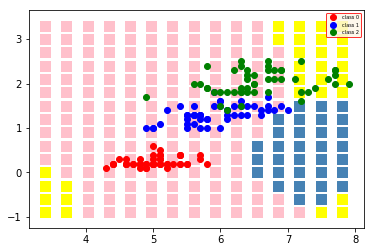

In [26]:
# fig, axs = plt.subplots(nrows=4, ncols=4)

#     colors = ['red', 'blue', 'green']
colors = ['red', 'blue', 'green']
test_colors = ['pink', 'SteelBlue', 'yellow']  # 0 pink, # SteelBlue, # yellow
i, j = 0, 3

scatter_size = 120

# for i in range(4):
#     for j in range(4):
#         fig, axs = plt.subplots(nrows=1, ncols=2)
for k in range(len(predictions)):
    if predictions[k] == 0:
        plt.scatter(x=plain_points[k][i], y=plain_points[k][j], s=scatter_size,   #  xs[i % 4, j % 4]
                                  c=test_colors[0], marker='s')
    elif predictions[k] == 1:
        plt.scatter(x=plain_points[k][i], y=plain_points[k][j], s=scatter_size, 
                                  c=test_colors[1], marker='s')
    elif predictions[k] == 2:
        plt.scatter(x=plain_points[k][i], y=plain_points[k][j], s=scatter_size, 
                                  c=test_colors[2], marker='s')
                
iris = datasets.load_iris()
x = iris.data
Y = iris.target
                
# for i in range(4):
#     for j in range(4):
for k in np.unique(Y, axis=0):
    plt.plot(x[Y == k, i],
                           x[Y == k, j],
                           'o', label='class {}'.format(k), color=colors[k]
                           )

    plt.legend(fontsize=5,
                             ncol=1,
                             facecolor='oldlace',
                             edgecolor='r'
                             )

#         for k in np.unique(arrY):
#             axs[1].plot(arrX[arrY == k, i],
#                                    arrX[arrY == k, j],
#                                    'o', label='class {}'.format(k), color=colors[k]
#                                    )

#             axs[i % 4, j % 4].legend(fontsize=5,
#                                      ncol=1,
#                                      facecolor='oldlace',
#                                      edgecolor='r'
#                                      )

fig.set_size_inches(10., 6.5)
plt.show()